# Trabajo Práctico Integrador - Análisis de Datos de Spotify

## Integrantes

- Porchietto, Damian Ignacio. Legajo: 0140834
- Muga, Maria Paula. Legajo: 0149176
- 

# Descripción del problema

Disponemos de seis archivos CSV con información de **41 106 canciones** publicadas entre las décadas de 1960 y 2010.  
Cada registro contiene:

* Metadatos básicos (`track`, `artist`, `uri`, `decade`);  
* **18 atributos de audio** extraídos de Spotify (p. ej. `danceability`, `energy`, `acousticness`, etc.);  
* Una etiqueta binaria `target` que indica si la canción fue **“exitosa”** dentro de su década (1) o no (0). El criterio de éxito proviene de rankings históricos (p. ej. listas Billboard/Spotify).

Nuestro objetivo general es **explorar y comprender**:

1. **Patrones de éxito**: ¿Qué características distinguen a las canciones exitosas de las que no lo fueron?  
2. **Evolución temporal**: ¿Cómo cambian esas características entre décadas?  
3. **Calidad del dato**: valores faltantes, outliers, consistencia de tipos y rangos.  

Al finalizar el EDA obtendremos hipótesis sólidas y un dataset limpio, listo para modelar (clasificación o clustering) o para elaborar visualizaciones comparativas.

> Documentar el contexto y los objetivos antes de tocar el código le da dirección al análisis y facilita la lectura a terceros.

---

## Importación de Bibliotecas

In [22]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
from scipy.stats import median_abs_deviation
from copy import deepcopy
import math
from scipy.stats import chi2_contingency

## Carga de Datos

In [14]:
decades = ['60', '70', '80', '90', '00', '10']
frames = []

for dec in decades:
    file = Path(f'dataset_spotify/dataset-of-{dec}s.csv')
    df = pd.read_csv(file)
    df['decade'] = '19' + dec if dec in ['60', '70', '80', '90'] else '20' + dec
    frames.append(df)

songs = pd.concat(frames, ignore_index=True)

display(songs.head())
print('Shape:', songs.shape)
songs.info()
print('Columnas disponibles:', songs.columns.tolist())

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,1,1960
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,1960
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,0,1960
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,0,1960
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,0,1960


Shape: (41106, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41106 non-null  object 
 1   artist            41106 non-null  object 
 2   uri               41106 non-null  object 
 3   danceability      41106 non-null  float64
 4   energy            41106 non-null  float64
 5   key               41106 non-null  int64  
 6   loudness          41106 non-null  float64
 7   mode              41106 non-null  int64  
 8   speechiness       41106 non-null  float64
 9   acousticness      41106 non-null  float64
 10  instrumentalness  41106 non-null  float64
 11  liveness          41106 non-null  float64
 12  valence           41106 non-null  float64
 13  tempo             41106 non-null  float64
 14  duration_ms       41106 non-null  int64  
 15  time_signature    41106 non-null  int64  
 16  chorus_hit        411

## Distribución de las variables

Conocer la distribución empírica de cada variable es la base para:

1. **Detectar valores atípicos y sesgos** (asimetrías, colas largas, picos).  
2. **Elegir transformaciones** (log, Box-Cox, escalado) antes de modelar.  
3. **Comparar subgrupos** (éxito vs. no éxito, décadas, géneros) y justificar pruebas estadísticas posteriores.  
4. **Comprender el rango natural** de cada atributo y validar supuestos de algoritmo (normalidad, homocedasticidad).

> **Enfoque**  
> * Variables numéricas → histogramas + KDE para forma y dispersión.  
> * Variables categóricas → conteos absolutos y proporciones.  
> * Etiqueta `target` → inspección de balance global.

---

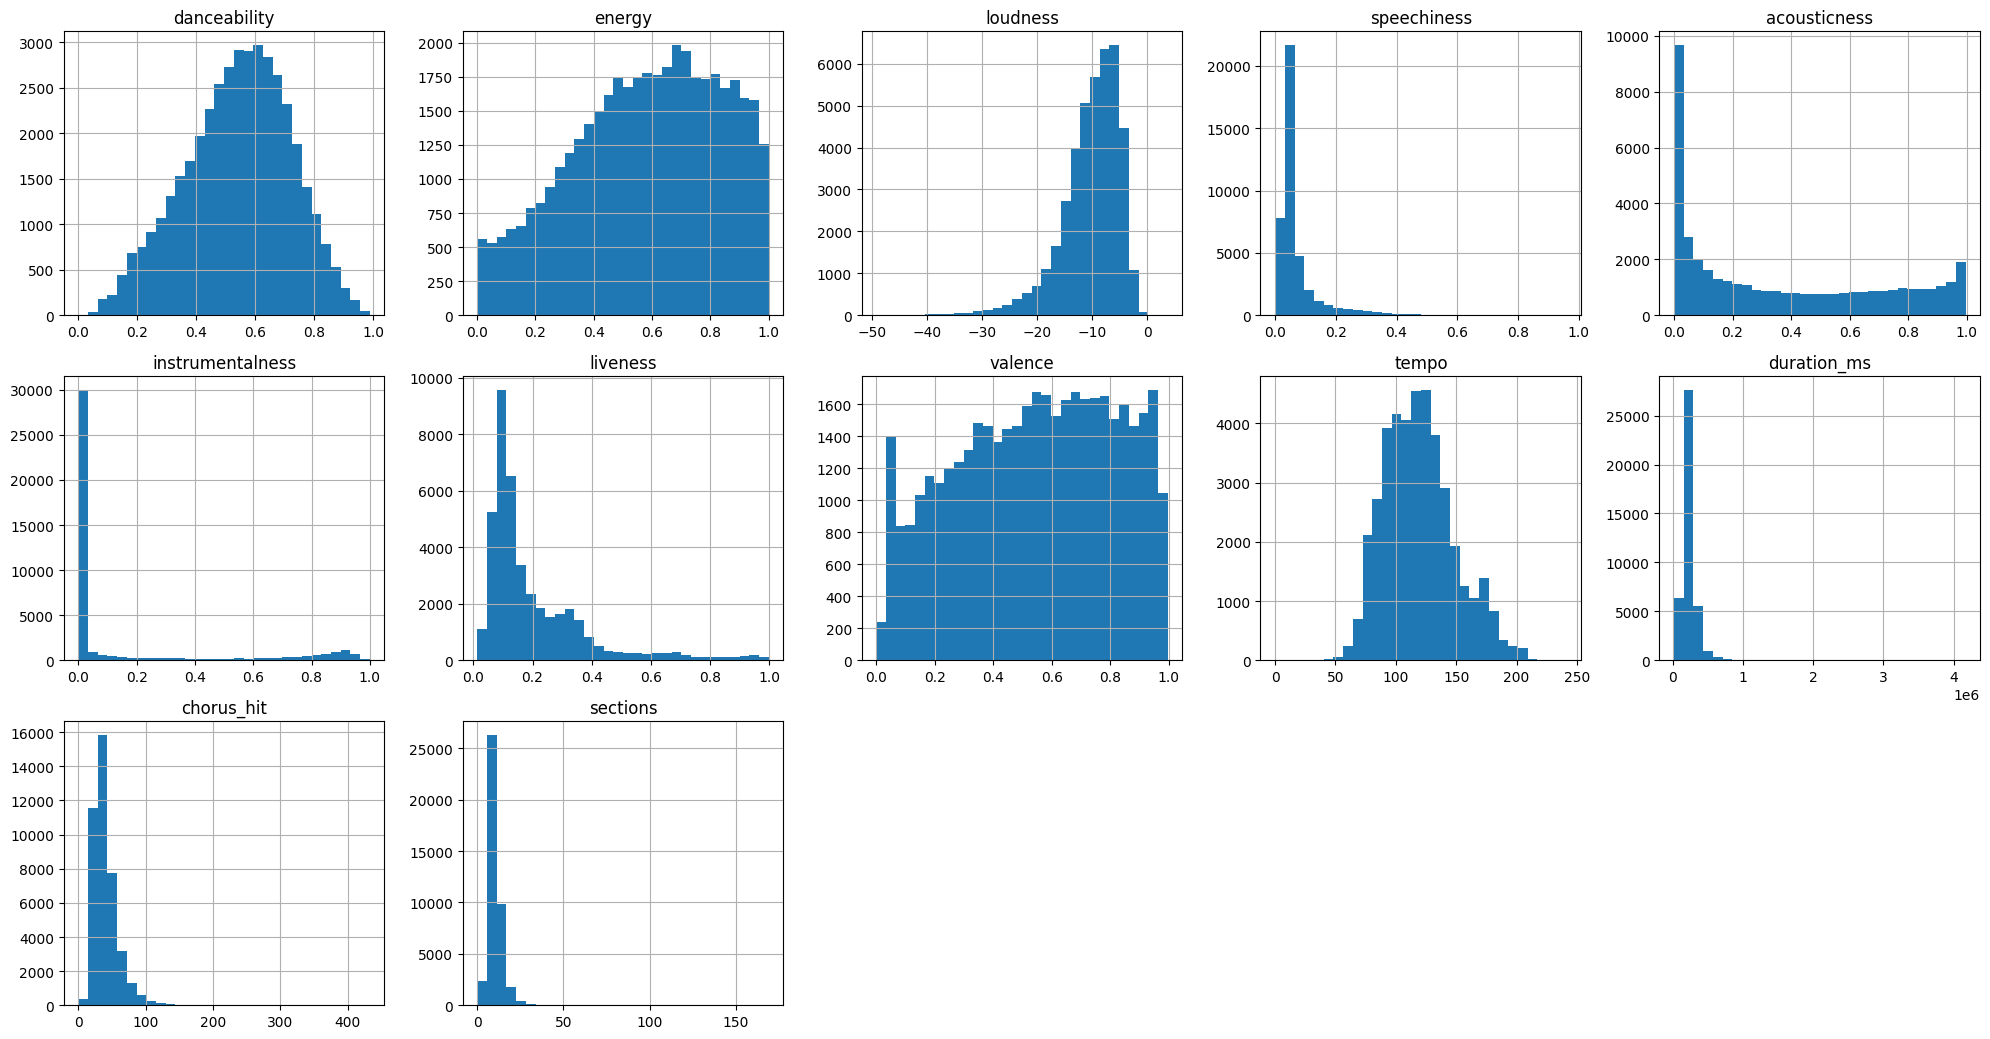

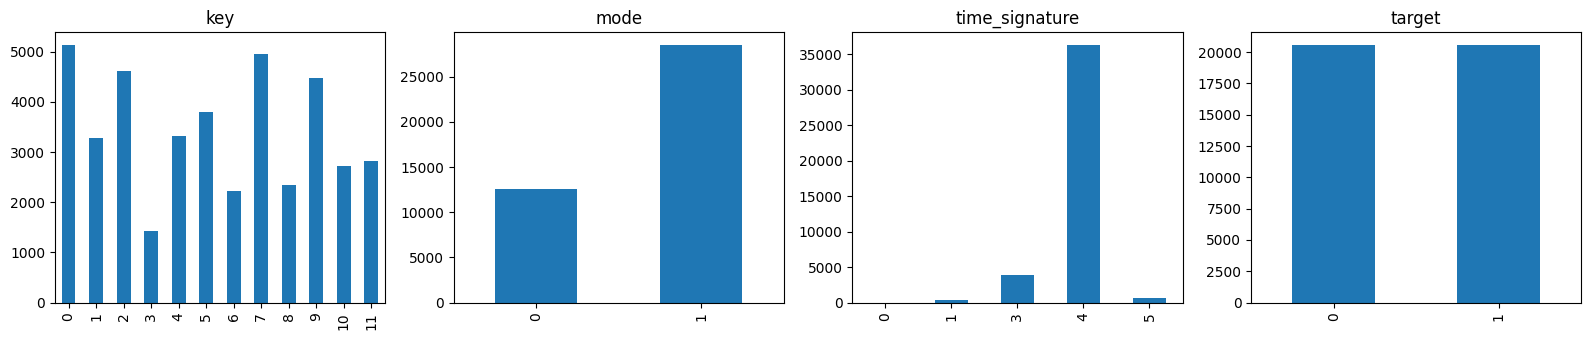

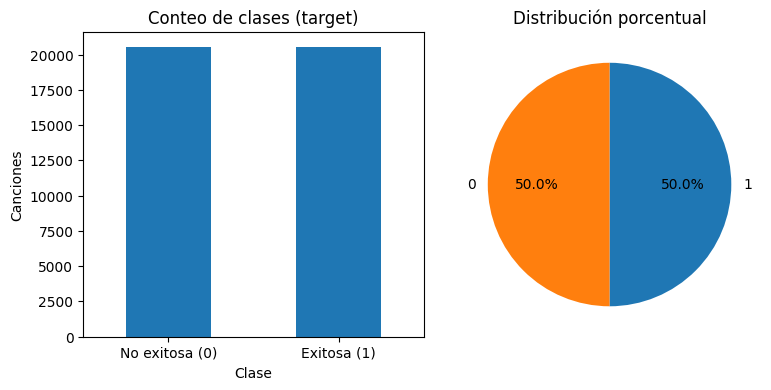

In [15]:
# --- listas de columnas -----------------------------------------------------
cat_cols = ['key', 'mode', 'time_signature', 'target']
num_cols = [c for c in songs.columns if c not in cat_cols + ['track', 'artist', 'uri', 'decade']]

# helper
def plot_grid(cols, kind, per_row=5):
    n = len(cols)
    rows = math.ceil(n / per_row)
    fig, axes = plt.subplots(rows, per_row, figsize=(4*per_row, 3.5*rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        if kind == 'hist':
            songs[col].hist(ax=ax, bins=30)
        else:  # barras
            songs[col].value_counts().sort_index().plot(kind='bar', ax=ax)
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # ejes vacíos si sobran celdas
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# numéricas
plot_grid(num_cols, kind='hist', per_row=5)

# categóricas 
plot_grid(cat_cols, kind='bar', per_row=5)

# Distribución global de la etiqueta target
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

songs['target'].value_counts().sort_index().plot(
    kind='bar',
    ax=axes[0]
)
axes[0].set_title('Conteo de clases (target)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Canciones')
axes[0].set_xticklabels(['No exitosa (0)', 'Exitosa (1)'], rotation=0)

# torta
songs['target'].value_counts(normalize=True).plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    ax=axes[1]
)
axes[1].set_title('Distribución porcentual')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


## Análisis e imputación de valores nulos

Antes de modelar necesitamos verificar si la ausencia de datos es:

* **MCAR** (Missing Completely at Random): se puede eliminar sin sesgar.  
* **MAR** o **MNAR**: dependerá de otras variables; conviene imputar.

### Estrategia adoptada

1. **Cuantificar**: conteo y % de nulos por columna.  
2. **Decidir**:
   * **Eliminar columnas** con > 30 % de nulos (aportan poco y podrían distorsionar).  
   * **Eliminar filas** con > 10 % de sus valores faltantes (observaciones demasiado incompletas).  
3. **Imputar**:
   * Numéricas → mediana (robusta a outliers).  
   * Categóricas → moda (valor más frecuente).  

> Si la inspección revela 0 % de nulos, este paso se documenta pero se omite la imputación.


### Tratamiento de outliers

| Variable        | Rango operativo aplicado | Criterio / motivación |
|-----------------|--------------------------|-----------------------|
| `tempo`         | 40 – 220 BPM            | Valores < 40 suelen ser errores de detección; > 220 muy raros y distorsionan escalas. |
| `duration_ms`   | 30 000 – 600 000 ms     | Menos de 30 s suele ser interludio/ruido; más de 10 min es atípico para singles. |
| `chorus_hit`    | 0 – 120 s               | A los 2 min el 99 % de los temas ya introdujo el estribillo; > 120 se considera outlier. |
| `sections`      | 1 – 30                  | Más de 30 fragmentos estructurales implica divisiones no usuales o errores de parsing. |
| `loudness`      | –40 – 0 dB              | Por encima de 0 dB no es físicamente plausible; por debajo de –40 dB se pierde relevancia musical. |
| Métricas 0-1 (`danceability`, etc.) | *sin cambio* | Están acotadas y los “outliers” son valores extremos pero válidos dentro de \[0, 1\]. |

> **Estrategia**: Winsorizamos (recortamos) en vez de eliminar filas para preservar volumen de datos y evitar sesgos por clase/época.

#### Box-plots comparativos (antes vs. después)

Para verificar visualmente el efecto de la winsorización se grafican, por cada
variable ajustada, dos box-plots en la misma fila:

| Columna A | Columna B |
|-----------|-----------|
| Datos originales (outliers incluidos) | Datos tras el recorte (`clip`) |

Esto permite confirmar que los extremos fueron recortados sin alterar la forma
central de la distribución.


,nulos,%
track,0,0.0
artist,0,0.0
uri,0,0.0
danceability,0,0.0
energy,0,0.0
key,0,0.0
loudness,0,0.0
mode,0,0.0
speechiness,0,0.0
acousticness,0,0.0


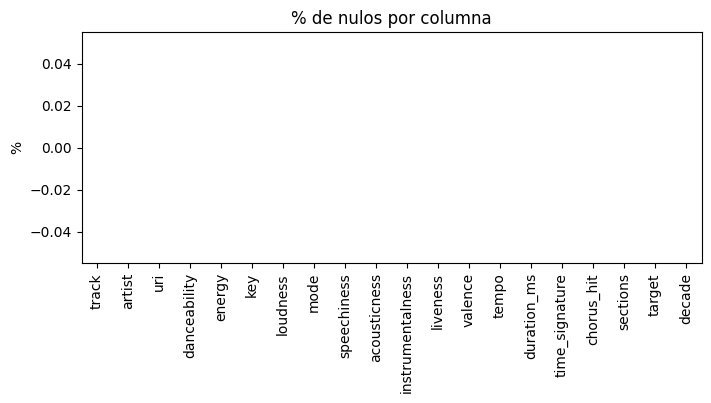

Columnas a eliminar (>30 % nulos): []
Filas    a eliminar (>10 % nulos): 0
No se detectaron valores nulos restantes; se omite imputación.


In [26]:
# cuantificación
nulls      = songs.isna().sum()
nulls_pct  = (nulls / len(songs) * 100).round(2)
null_summary = pd.DataFrame({'nulos': nulls, '%': nulls_pct})

display(null_summary.sort_values('%', ascending=False))

# Visual rápido
plt.figure(figsize=(8, 3))
null_summary['%'].plot(kind='bar')
plt.title('% de nulos por columna')
plt.ylabel('%')
plt.show()

# Decisiones
cols_drop = null_summary[null_summary['%'] > 30].index.tolist()
rows_drop = songs.index[songs.isna().mean(axis=1) > 0.10]

print(f'Columnas a eliminar (>30 % nulos): {cols_drop}')
print(f'Filas    a eliminar (>10 % nulos): {len(rows_drop)}')

songs_clean = songs.drop(columns=cols_drop).drop(index=rows_drop)

# Imputación
if songs_clean.isna().sum().sum() == 0:
    print('No se detectaron valores nulos restantes; se omite imputación.')
else:
    num_cols = songs_clean.select_dtypes(include=['float64', 'int64']).columns
    cat_cols = songs_clean.select_dtypes(include=['category', 'object', 'bool']).columns

    # imputación numérica
    for col in num_cols:
        median = songs_clean[col].median()
        songs_clean[col].fillna(median, inplace=True)

    # imputación categórica
    for col in cat_cols:
        mode = songs_clean[col].mode()[0]
        songs_clean[col].fillna(mode, inplace=True)

    print('Imputación completada.')
    # reporte final
    print('Nulos restantes:', songs_clean.isna().sum().sum())


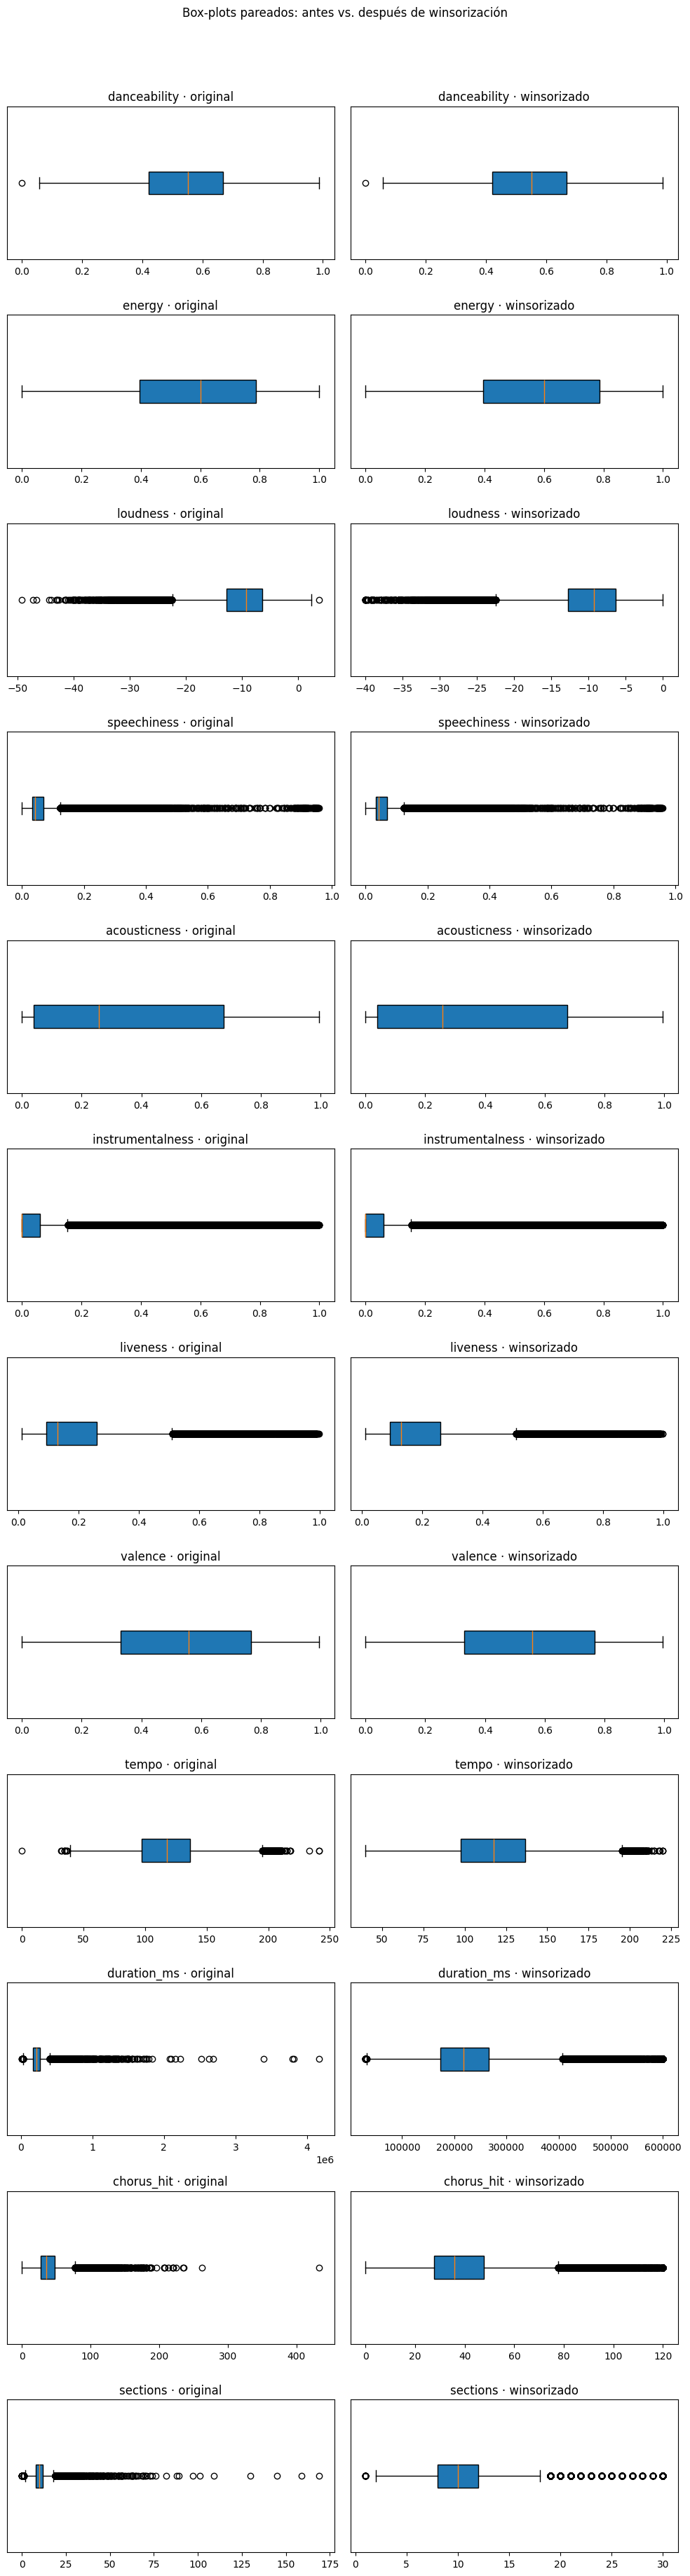

,variable,lower_bound,upper_bound,orig_min,orig_max,win_min,win_max,clipped_lower,clipped_upper,clipped_total,clipped_pct,orig_mean,win_mean
1,duration_ms,30000,600000,15168.000,4170227.000,30000.0,600000.0,32,504,536,1.30,234877.55,231171.34
3,sections,1,30,0.000,169.000,1.0,30.0,15,275,290,0.71,10.48,10.38
2,chorus_hit,0,120,0.000,433.182,0.0,120.0,0,227,227,0.55,40.11,39.96
4,loudness,-40,0,-49.253,3.744,-40.0,0.0,20,6,26,0.06,-10.22,-10.22
0,tempo,40,220,0.000,241.423,40.0,220.0,12,3,15,0.04,119.34,119.34


In [30]:
songs_winz = songs.copy()

clip_ranges = {
    'tempo':        (40, 220),
    'duration_ms':  (30_000, 600_000),
    'chorus_hit':   (0, 120),
    'sections':     (1, 30),
    'loudness':     (-40, 0)
}
for col, (lo, hi) in clip_ranges.items():
    songs_winz[col] = songs_winz[col].clip(lo, hi)

num_cols = [c for c in songs.columns 
            if c not in ['track', 'artist', 'uri', 'decade', 
                         'key', 'mode', 'time_signature', 'target']]

import matplotlib.pyplot as plt
import math

rows = len(num_cols)
fig, axes = plt.subplots(rows, 2, figsize=(10, 3*rows))  # 2 columnas: original / wins

if rows == 1:
    axes = np.array([axes])

for i, col in enumerate(num_cols):
    # original
    axes[i, 0].boxplot(songs[col], vert=False, patch_artist=True)
    axes[i, 0].set_title(f'{col} · original')
    axes[i, 0].set_yticks([])

    # winsorizado
    axes[i, 1].boxplot(songs_winz[col], vert=False, patch_artist=True)
    axes[i, 1].set_title(f'{col} · winsorizado')
    axes[i, 1].set_yticks([])

fig.suptitle('Box-plots pareados: antes vs. después de winsorización', y=1.02)
plt.tight_layout()
plt.show()

# Métricas del recorte (sin cambios)
import pandas as pd
rows_stats = []
n_total = len(songs)

for col, (low, high) in clip_ranges.items():
    orig = songs[col]
    winz = songs_winz[col]

    n_below = (orig < low).sum()
    n_above = (orig > high).sum()

    rows_stats.append({
        'variable': col,
        'lower_bound': low,
        'upper_bound': high,
        'orig_min': orig.min(),
        'orig_max': orig.max(),
        'win_min': winz.min(),
        'win_max': winz.max(),
        'clipped_lower': n_below,
        'clipped_upper': n_above,
        'clipped_total': n_below + n_above,
        'clipped_pct': round((n_below + n_above) / n_total * 100, 2),
        'orig_mean': round(orig.mean(), 2),
        'win_mean': round(winz.mean(), 2)
    })

metrics_df = pd.DataFrame(rows_stats)
display(metrics_df.sort_values('clipped_pct', ascending=False))

## Relación de las variables con `target`

Para una etiqueta binaria, conviene analizar:

| Tipo de variable | Métrica numérica | Visualización usada |
|------------------|------------------|---------------------|
| **Numéricas**    | Correlación punto–biserial (≡ Pearson con 0/1) | Box-plots separados por clase |
| **Categóricas**  | Asociación χ² → Cramér V | Barras normalizadas por clase |

> *Interpretación rápida:*  
> * **|ρ| ≈ 0.1** efecto débil · **≈ 0.3** moderado · **≥ 0.5** fuerte.  
> * **Cramér V** con el mismo umbral (porque su rango también es \[0, 1\]).


,|ρ|
variable,
instrumentalness,0.407638
danceability,0.346097
loudness,0.286269
valence,0.251147
acousticness,0.246036
energy,0.177142
duration_ms,0.058921
liveness,0.051445
sections,0.049574


,cramers_v
variable,
time_signature,0.155
mode,0.080
key,0.061


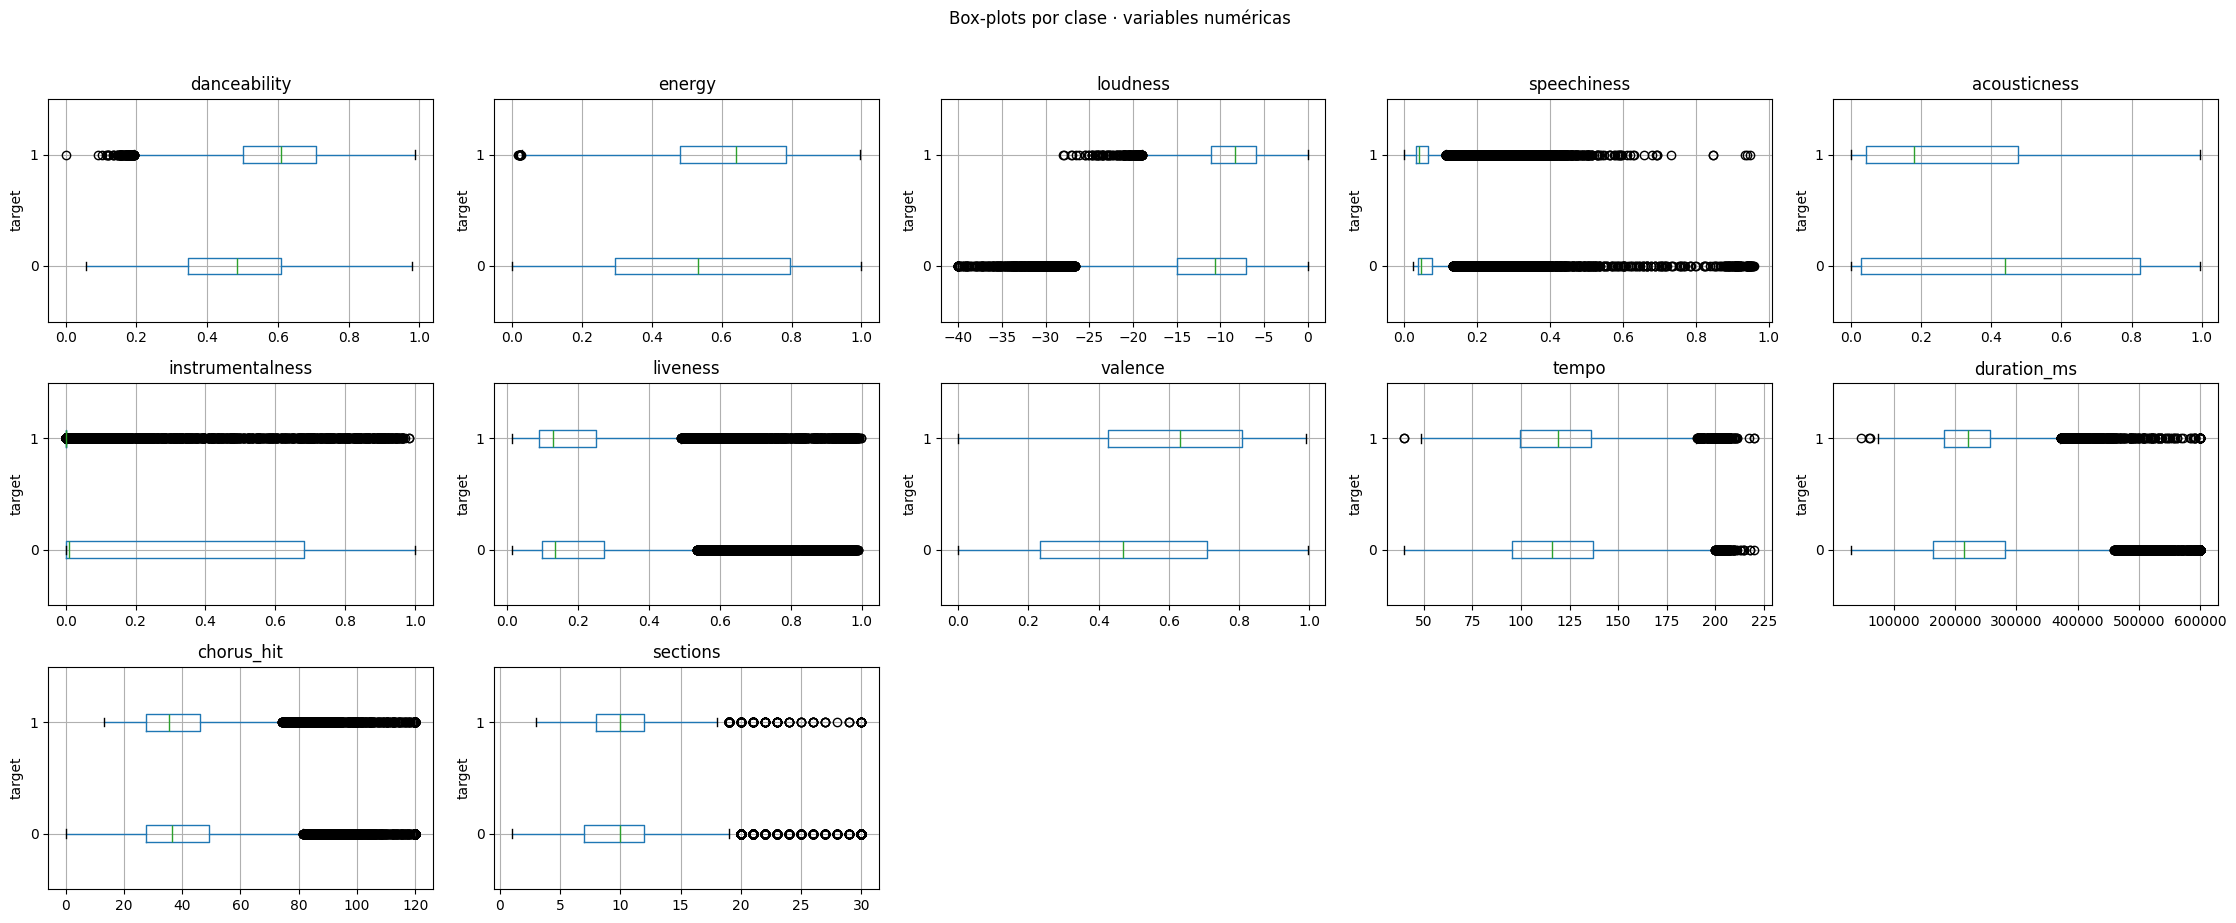

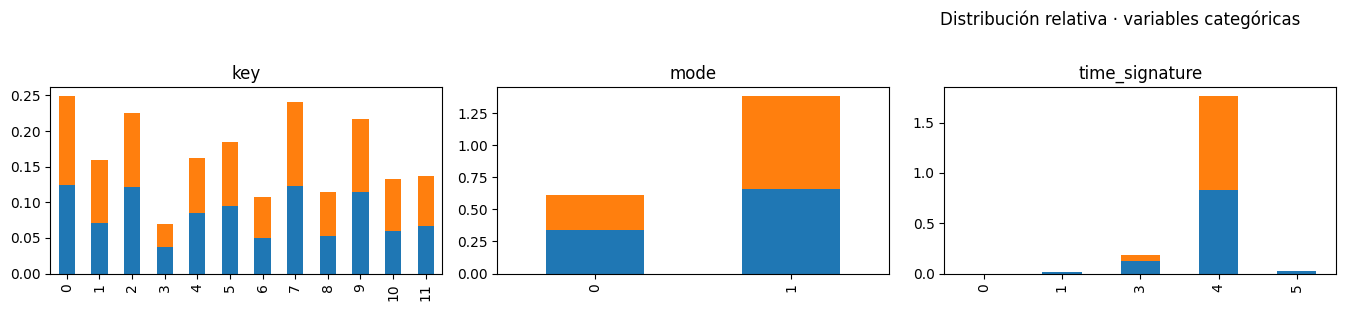

In [31]:

# pearson para numéricas 
num_cols = [c for c in songs_winz.columns 
            if c not in ['track','artist','uri','decade','key','mode',
                         'time_signature','target']]

corr_series = songs_winz[num_cols].corrwith(songs_winz['target'])
corr_df = corr_series.abs().sort_values(ascending=False).to_frame('|ρ|').rename_axis('variable')

display(corr_df)

# Cramér V para categóricas
def cramers_v(confusion):
    chi2 = chi2_contingency(confusion)[0]
    n    = confusion.values.sum()
    r,k  = confusion.shape
    return np.sqrt(chi2 / (n * (min(k,r)-1)))

cat_cols = ['key','mode','time_signature']
rows = []
for col in cat_cols:
    ct = pd.crosstab(songs_winz[col], songs_winz['target'])
    rows.append({'variable': col, 'cramers_v': round(cramers_v(ct), 3)})
cramers_df = pd.DataFrame(rows).set_index('variable').sort_values('cramers_v', ascending=False)

display(cramers_df)

# Box-plots numéricos por clase
per_row, n = 5, len(num_cols)
rows = int(np.ceil(n / per_row))
fig, axes = plt.subplots(rows, per_row, figsize=(4.5*per_row, 3*rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    songs_winz.boxplot(column=col, by='target', ax=axes[i], vert=False)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_yticklabels(['0','1'])
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Box-plots por clase · variables numéricas', y=1.02)
plt.tight_layout()
plt.show()

# Barras normalizadas de categóricas
rows = int(np.ceil(len(cat_cols) / per_row))
fig, axes = plt.subplots(rows, per_row, figsize=(4.5*per_row, 3*rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    (songs_winz
      .groupby(['target', col])
      .size()
      .groupby(level=0)
      .apply(lambda s: s / s.sum())
      .unstack()
      .T
      .plot(kind='bar', stacked=True, ax=axes[i]))
    axes[i].set_title(col)
    axes[i].legend([],[], frameon=False)
    axes[i].set_xlabel('')
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Distribución relativa · variables categóricas', y=1.02)
plt.tight_layout()
plt.show()

Tabla de |ρ| → los valores más altos indican features numéricas que difieren sustancialmente entre canciones exitosas y no exitosas.

Tabla de Cramér V → para key, mode, time_signature, un valor > 0.1 sugiere asociación; > 0.3 empieza a ser relevante.

Box-plots → inspeccioná cuán separadas están las medianas entre clases.

Barras normalizadas → verifican si alguna categoría domina en la clase 1 frente a la 0.

## Correlaciones entre variables numéricas

Objetivos principales:

1. **Detectar multicolinealidad**  
   * Correlaciones alto-positivas (>|0.80|) sugieren redundancia.
2. **Identificar grupos de métricas afines**  
   * p. ej. `energy` y `loudness` suelen ir de la mano.
3. **Guiar la ingeniería de features**  
   * Eliminar, combinar o estandarizar variables altamente correlacionadas.

> **Interpretación**  
> * |ρ| ≈ 0 – 0.3 → débil · 0.3 – 0.6 → moderada · 0.6 – 0.8 → fuerte · > 0.8 → muy fuerte.


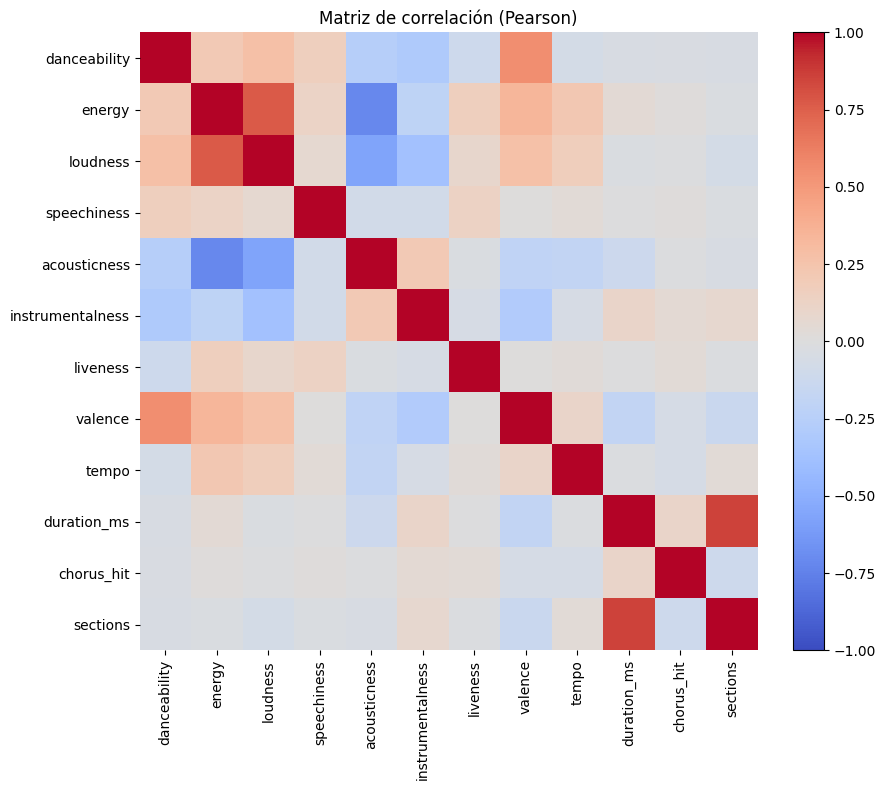

,var1,var2,corr,abs_corr
64,duration_ms,sections,0.854343,0.854343
11,energy,loudness,0.773250,0.773250
13,energy,acousticness,-0.715088,0.715088
22,loudness,acousticness,-0.567185,0.567185
6,danceability,valence,0.553858,0.553858
23,loudness,instrumentalness,-0.374654,0.374654
16,energy,valence,0.341427,0.341427
4,danceability,instrumentalness,-0.301915,0.301915
46,instrumentalness,valence,-0.287047,0.287047
1,danceability,loudness,0.274148,0.274148


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seleccionar variables numéricas
num_cols = [c for c in songs_winz.columns
            if c not in ['track','artist','uri','decade',
                         'key','mode','time_signature','target']]

# Matriz de correlación (Pearson)
corr_mat = songs_winz[num_cols].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cax, fraction=0.046, pad=0.04)

# etiquetas
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)

# dibujar rejilla fina
for edge, spine in ax.spines.items():
    spine.set_visible(False)

plt.title('Matriz de correlación (Pearson)')
plt.tight_layout()
plt.show()

# op pares altamente correlacionados
# (solo triángulo superior sin la diagonal)
corr_pairs = (
    corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
            .stack()
            .reset_index()
            .rename(columns={'level_0':'var1', 'level_1':'var2', 0:'corr'})
            .assign(abs_corr=lambda df: df['corr'].abs())
            .sort_values('abs_corr', ascending=False)
)

# mostrar los 10 pares más fuertes
display(corr_pairs.head(10))
